# CycleGAN


In [ ]:
import torch
from torch import nn
import numpy as np
import os
import PIL
from PIL import Image
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

device = torch.device("cuda:2" if (torch.cuda.is_available()) else "cpu")

In [ ]:
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, path='/home/jovyan/work/CycleGAN/', gen_name=''):
    x = next(iter(val_loader))
    x = x.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization
        save_image(y_fake, path + f"fake_{gen_name}_{epoch}.png")
        if (epoch==0):
            save_image(x * 0.5 + 0.5, path + f"input_{gen_name}_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
class LandDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        self.transform_input = A.Compose([
                A.Resize(width=256, height=256),
                A.HorizontalFlip(p=0.5),
                #A.ColorJitter(p=0.2),
                A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
                ToTensorV2(),
            ])

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        image = self.transform_input(image=image)["image"]
        
        return image

torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])


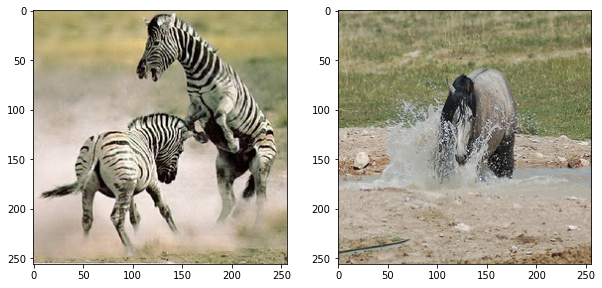

In [ ]:
domainA = LandDataset("CycleGAN/horse2zebra/trainA")
loaderA = DataLoader(domainA, batch_size=4, shuffle=True)
domainB = LandDataset("CycleGAN/horse2zebra/trainB")
loaderB = DataLoader(domainB, batch_size=4, shuffle=True)


fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
x = next(iter(loaderB))
print(x.shape)
x=x*0.5+0.5
plt.imshow(np.transpose(x[0].numpy(), (1, 2, 0)))
fig.add_subplot(1, 2, 2)
x = next(iter(loaderA))
x=x*0.5+0.5
print(x.shape)
plt.imshow(np.transpose(x[0].numpy(), (1, 2, 0)))

## Descriminator architecture
Where Ck = Convolution-**InstanceNorm**-LeakyReLU layer
with k filters

The 70 × 70 discriminator architecture is:
C64-C128-C256-C512

In [ ]:
class CBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=2):
        super(CBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_ch),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        return self.block(x)


class Disc(nn.Module):
    def __init__(self):
        super(Disc, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        self.blocks = nn.Sequential(
            CBlock(64, 128),
            CBlock(128, 256),
            CBlock(256, 512, 1),
        )
        self.last_conv = nn.Conv2d(512, 1, 4, 1, 1, padding_mode="reflect")
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.blocks(x)
        return torch.sigmoid(self.last_conv(x))
    
# x = next(iter(loaderB))
# model = Desc()
# print(x.shape)
# print(model(x).shape)

## Generator Architecture

I did my best to make G model as close as possible to their implementation. The network with 9 residual blocks consists of:

c7s1-64,

d128,d256,

R256,R256,R256,R256,R256,R256,R256,R256,R256,

u128,u64,

c7s1-3

where c7s1-k denote a 7×7 Convolution-InstanceNormReLU layer with k filters and stride 1. dk denotes a 3 × 3
Convolution-InstanceNorm-ReLU layer with k filters and
stride 2. Reflection padding was used to reduce artifacts.
Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both
layer. uk denotes a 3 × 3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride 1/2.

There's no info about output_paddings etc, you should better watch there implementation of G model: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [ ]:
class CSK(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(CSK, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 7, stride, 3, padding_mode='reflect'),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.block(x)


class DK(nn.Module):
    def __init__(self, in_ch, out_ch, stride=2):
        super(DK, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride, 1, padding_mode='reflect'),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.block(x)
    
    
class RK(nn.Module):
    def __init__(self, in_ch):
        super(RK, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(in_ch),
            nn.ReLU(), 
            
            nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(in_ch),
            nn.Identity()
        )
    
    def forward(self, x):
        return x + self.block(x)
    
    
class UK(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UK, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, 2, 1, output_padding=1,), 
            nn.InstanceNorm2d(out_ch),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.block(x)
    
    
class Gen(nn.Module):
    def __init__(self, d=64, res_block_num = 9):
        super(Gen, self).__init__()
        self.init = CSK(3, d)
        
        self.down1 = DK(d, d*2)
        self.down2 = DK(d*2, d*4)
        
        res_list = []
        for i in range(res_block_num):
            res_list.append(RK(d*4))
        self.res_blocks = nn.Sequential(*res_list)    
        
        self.up1 = UK(d*4, d*2)
        self.up2 = UK(d*2, d)
        
        self.final = nn.Conv2d(d, 3, 7, 1, 3, padding_mode='reflect')
        
    def forward(self, x):
        x = self.init(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.res_blocks(x)
        x = self.up1(x)
        x = self.up2(x)
        return self.final(x)
        
# model = Gen()
# x = torch.rand([1, 3, 128, 128])
# print(model(x).shape)

In [ ]:
def weights_init(m, mean=0.0, std=0.02):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, mean, std)
        
netG_AtoB = Gen().to(device)
netG_AtoB.apply(weights_init) 
netD_AtoB = Disc().to(device)
netD_AtoB.apply(weights_init) 

netG_BtoA = Gen().to(device)
netG_BtoA.apply(weights_init) 
netD_BtoA = Disc().to(device)
netD_BtoA.apply(weights_init) 

optG = optim.Adam(list(netG_AtoB.parameters())+list(netG_BtoA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optD = optim.Adam(list(netD_AtoB.parameters())+list(netD_BtoA.parameters()), lr=0.0002, betas=(0.5, 0.999))

print('weights initialized')

weights initialized


In [ ]:
load_checkpoint('netD_AtoB.pth.tar', netD_AtoB, optD)
load_checkpoint('netD_BtoA.pth.tar', netD_BtoA, optD)
load_checkpoint('netG_AtoB.pth.tar', netG_AtoB, optG)
load_checkpoint('netG_BtoA.pth.tar', netG_BtoA, optG)

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


In [ ]:
epochs = 300
LAMBDA_ID = 5
LAMBDA_CYC = 10
mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()
val_loaderA = DataLoader(domainA, batch_size=1)
val_loaderB = DataLoader(domainB, batch_size=1)
#G_, D_ = [], []

for epoch in range(epochs):
    g, d = [], []
    for A, B in zip(loaderA, loaderB):
        A, B = A.to(device), B.to(device)
        
        ## train discriminator AtoB ##
        # real images
        output = netD_AtoB(B)
        real_loss = mse_loss(output, torch.ones_like(output))
        
        # fake loss
        fake_AtoB = netG_AtoB(A)
        output = netD_AtoB(fake_AtoB.detach())
        fake_loss = mse_loss(output, torch.zeros_like(output))
        
        D_loss_AtoB = (real_loss + fake_loss)/2
        
        ## train discriminator BtoA ## 
        # real images
        output = netD_BtoA(A)
        real_loss = mse_loss(output, torch.ones_like(output))
        
        # fake loss
        fake_BtoA = netG_BtoA(B)
        output = netD_BtoA(fake_BtoA.detach())
        fake_loss = mse_loss(output, torch.zeros_like(output))
        
        D_loss_BtoA = (real_loss + fake_loss)/2
        
        ## disc step
        D_loss = D_loss_BtoA + D_loss_AtoB
        optD.zero_grad()
        D_loss.backward()
        optD.step()
        
        ## train generators ##
        # adversarial loss for both gens
        output = netD_AtoB(fake_AtoB)
        adv_loss_AtoB = mse_loss(output, torch.ones_like(output))
        output = netD_BtoA(fake_BtoA)
        adv_loss_BtoA = mse_loss(output, torch.ones_like(output))
        
        adv_loss = adv_loss_AtoB + adv_loss_BtoA
        
        # identity loss for both gens
        A_ = netG_BtoA(A)
        id_lossA = l1_loss(A_, A)
        B_ = netG_AtoB(B)
        id_lossB = l1_loss(B_, B)
        
        id_loss = id_lossA + id_lossB
        
        # cycle loss for both gens
        cycleA = netG_BtoA(fake_AtoB) 
        cyc_lossA = l1_loss(cycleA, A)
        cycleB = netG_AtoB(fake_BtoA)
        cyc_lossB = l1_loss(cycleB, B)
        
        cyc_loss = cyc_lossA + cyc_lossB
        
        ## final objective ##
        loss = adv_loss + LAMBDA_ID * id_loss + LAMBDA_CYC * cyc_loss
        optG.zero_grad()
        loss.backward()
        optG.step()
        
        #G_.append(loss)
        #D_.append(D_loss)

    print(f'epoch: {epoch}, D_loss: {D_loss.item()}, G_loss: {loss.item()}, id_loss: {LAMBDA_ID * id_loss}, cyc_loss: {LAMBDA_CYC * cyc_loss}')    
        
    if ((epoch)%5==0):
        save_some_examples(netG_AtoB, val_loaderA, epoch, "AtoB")
        save_some_examples(netG_BtoA, val_loaderB, epoch, "BtoA")
        
    if ((epoch)%10==0):
        save_checkpoint(netG_AtoB, optG, filename="netG_AtoB.pth.tar")
        save_checkpoint(netD_AtoB, optD, filename="netD_AtoB.pth.tar")
        save_checkpoint(netG_BtoA, optG, filename="netG_BtoA.pth.tar")
        save_checkpoint(netD_BtoA, optD, filename="netD_BtoA.pth.tar")
        
        
#print(G_)
print('==')
#print(D_)
        

In [ ]:
def save_examples(gen1, gen2, data_loader, path='/CycleGAN/'):
    x = next(iter(data_loader))
    x = x.to(device)
    gen1.eval()
    gen2.eval()
    with torch.no_grad():
        y_fake = gen1(x)
        g_fake = gen2(y_fake)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization
        g_fake = g_fake * 0.5 + 0.5  
        save_image(y_fake, path + f"fake_gen1.png")
        save_image(g_fake, path + f"fake_gen2.png")
        save_image(x * 0.5 + 0.5, path + f"input.png")
    gen1.train()
    gen2.train()

domainA = LandDataset("/CycleGAN/horse2zebra/testA")
domainB = LandDataset("/CycleGAN/horse2zebra/testB")
loaderA_test = DataLoader(domainA, batch_size=64, shuffle=True)
loaderB_test = DataLoader(domainB, batch_size=64, shuffle=True)
#save_examples(netG_AtoB, netG_BtoA, loaderA_test)
save_examples(netG_BtoA, netG_AtoB, loaderB_test)